In [103]:
#pip install tensorflow
#pip install numpy
#pip install pandas
#pip install matplotlib

In [104]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [105]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 978 files belonging to 3 classes.
Using 783 files for training.
Found 978 files belonging to 3 classes.
Using 195 files for validation.


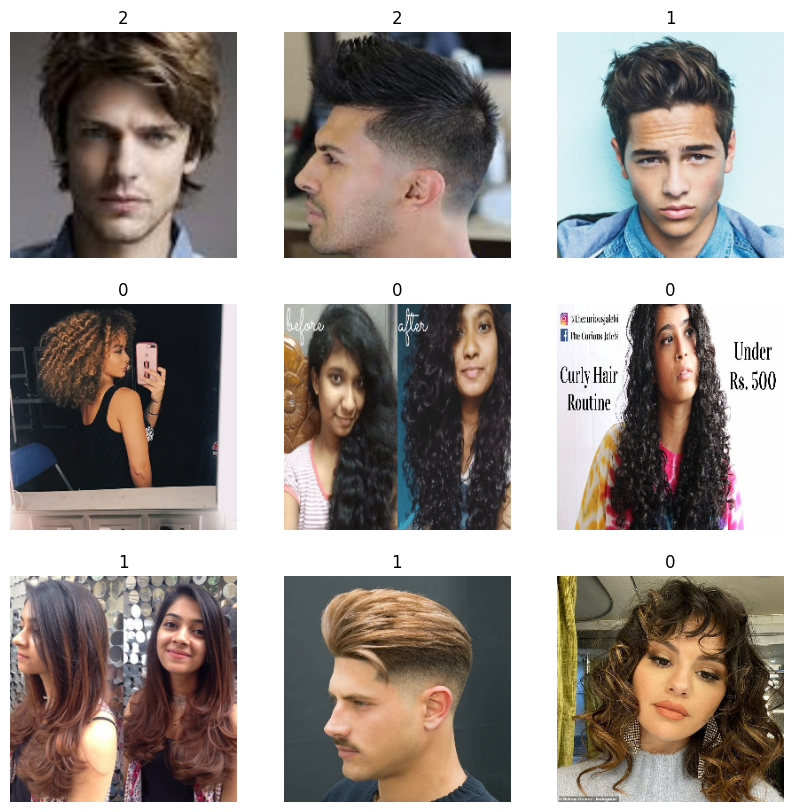

In [106]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

In [107]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(keras.Input(shape=image_size + (3,)))  # 64, 64, 3
model.add(layers.Rescaling(1.0 / 255))

# Convolutional Layer 2
model.add(layers.Conv2D(filters=16, kernel_size=7, strides=2, padding='same', dilation_rate=1))
model.add(layers.BatchNormalization(synchronized=True))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))  

model.add(layers.Conv2D(filters=32, kernel_size=7, strides=2, padding='same', dilation_rate=1))
#model.add(layers.BatchNormalization(synchronized=True))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) 

# Convolutional Layer 2
model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))  

# Convolutional Layer 3
model.add(layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same', dilation_rate=1))
model.add(layers.Activation("relu"))
#model.add(layers.MaxPooling2D(pool_size=(2, 2))) 

# Global Average Pooling Layer
model.add(layers.GlobalAveragePooling2D())

# Dense Layer
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

epochs = 50



In [108]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

def learning_rate_schedule(epoch, initial_lr=0.001):
    if epoch < 10:
        return initial_lr
    elif epoch < 20:
        return initial_lr * 0.1  # Reduce learning rate by a factor of 10 after 10 epochs
    else:
        return initial_lr * 0.01  # Further reduce learning rate by a factor of 10 after 20 epochs

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])
#model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/50


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.3442 - loss: 1.1000 - val_accuracy: 0.3795 - val_loss: 1.0972
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.4121 - loss: 1.0581 - val_accuracy: 0.3795 - val_loss: 1.0901
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.4884 - loss: 0.9856 - val_accuracy: 0.4718 - val_loss: 1.0687
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.5502 - loss: 0.9068 - val_accuracy: 0.3436 - val_loss: 1.1212
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.5828 - loss: 0.8543 - val_accuracy: 0.4513 - val_loss: 0.9964
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.6581 - loss: 0.7486 - val_accuracy: 0.4462 - val_loss: 1.1069
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.6508 - loss: 0.7579 - val_accuracy: 0.5436 - val_loss: 0.9499
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.7341 - loss: 0.6172 - val_accuracy: 0.5385 - val_

In [109]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
This image is 0.99 percent curly hair, 0.00 percent straight hair, and 0.01 percent wavy hair.
